<a href="https://colab.research.google.com/github/Anusri-J/Live-PM2.5-Nowcast-and-Forecast/blob/main/Live_PM2_5_Nowcast_and_Forecast_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data Acquisition**

In [92]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

In [93]:
# Provided the coordinates of location to scrape the data from Open-Meteo
lat, lon = 13.0827, 80.2707 # Chennai (change as needed)

In [94]:
# === Function to extract datetime and PM2.5 from Open-Meteo Air Quality ===
def fetch_openmeteo_pm25(lat, lon):
    """Fetch PM2.5 for the past 72 hours (3 days) from Open-Meteo Air Quality API."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "pm2_5",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()["hourly"]

    df = pd.DataFrame({
        "utc_time": pd.to_datetime(js["time"], utc=True),
        "pm25": js["pm2_5"]
    })
    # Keep only last 72 hours
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

In [95]:
# Saved the extracted data with dataframe named as pm25_data
pm25_data = fetch_openmeteo_pm25(lat, lon)

In [96]:
# Validated the count of pm25_data extracted from Open-Meteo Air Quality
print(f"Number of hours retrieved: {len(pm25_data)}")

Number of hours retrieved: 72


In [97]:
# Ensured on printing the data frame of pm25_data to validate the range
pm25_data

,utc_time,pm25
13,2025-10-27 13:00:00+00:00,9.5
14,2025-10-27 14:00:00+00:00,8.6
15,2025-10-27 15:00:00+00:00,9.0
16,2025-10-27 16:00:00+00:00,8.9
17,2025-10-27 17:00:00+00:00,8.6
...,...,...
80,2025-10-30 08:00:00+00:00,24.4
81,2025-10-30 09:00:00+00:00,22.0
82,2025-10-30 10:00:00+00:00,20.3
83,2025-10-30 11:00:00+00:00,19.3


In [98]:
# === Function to extract datetime and required variables from Open-Meteo Forecast ===
def fetch_openmeteo_weather(lat, lon):
    """Fetch hourly weather variables from Open-Meteo."""
    # Current UTC date
    end_date = datetime.now(timezone.utc)
    # Start date = Last 72 hours
    start_date = end_date - timedelta(hours=72)

    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    hourly = r.json()["hourly"]
    df = pd.DataFrame({"utc_time": pd.to_datetime(hourly["time"], utc=True)})
    for k, v in hourly.items():
        if k != "time":
            df[k] = v
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df

In [99]:
# Saved the extracted data and print the count of extracted from Open-Meteo Forecast
whether_data = fetch_openmeteo_weather(lat, lon)
print(f"Number of hours retrieved: {len(whether_data)}")

Number of hours retrieved: 72


In [100]:
# Ensured on printing the data frame of whether_data to validate the range
whether_data

,utc_time,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure
13,2025-10-27 13:00:00+00:00,25.5,95,4.6,321,1004.6
14,2025-10-27 14:00:00+00:00,25.4,94,5.9,317,1005.4
15,2025-10-27 15:00:00+00:00,25.3,94,6.1,298,1005.9
16,2025-10-27 16:00:00+00:00,25.2,94,5.6,310,1005.9
17,2025-10-27 17:00:00+00:00,25.1,94,8.0,324,1005.8
...,...,...,...,...,...,...
80,2025-10-30 08:00:00+00:00,32.3,59,5.5,212,1006.3
81,2025-10-30 09:00:00+00:00,32.5,59,5.2,205,1005.9
82,2025-10-30 10:00:00+00:00,32.4,59,4.7,212,1005.5
83,2025-10-30 11:00:00+00:00,32.0,60,4.6,162,1005.5


In [101]:
# Merge pm25_data + whether_data (nearest timestamp, 1h tolerance)
merged = pd.merge_asof(
    pm25_data.sort_values("utc_time"),
    whether_data.sort_values("utc_time"),
    on="utc_time",
    direction="nearest",
    tolerance=pd.Timedelta("1h")
    )

In [102]:
# Final data set after web scrape
merged

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure
0,2025-10-27 13:00:00+00:00,9.5,25.5,95,4.6,321,1004.6
1,2025-10-27 14:00:00+00:00,8.6,25.4,94,5.9,317,1005.4
2,2025-10-27 15:00:00+00:00,9.0,25.3,94,6.1,298,1005.9
3,2025-10-27 16:00:00+00:00,8.9,25.2,94,5.6,310,1005.9
4,2025-10-27 17:00:00+00:00,8.6,25.1,94,8.0,324,1005.8
...,...,...,...,...,...,...,...
67,2025-10-30 08:00:00+00:00,24.4,32.3,59,5.5,212,1006.3
68,2025-10-30 09:00:00+00:00,22.0,32.5,59,5.2,205,1005.9
69,2025-10-30 10:00:00+00:00,20.3,32.4,59,4.7,212,1005.5
70,2025-10-30 11:00:00+00:00,19.3,32.0,60,4.6,162,1005.5


**2) Feature Engineering**

**Lags (past snapshots)**



*   A lag is simply the value of a variable from a previous time step,like “PM2.5 one hour ago.”
*   It gives the model memory of the past, helping it learn trends and patterns over time.

In [103]:
# Selected lags 1–3 (short + long-term) for 24–48 hr predictions
pm_lags = [1,2,3]  # choose lags depending on forecast horizon
for lag in pm_lags:
    merged[f"pm25_lag{lag}"] = merged["pm25"].shift(lag)

**Rolling statistics (past trends)**

Rolling statistics summarize recent past values (like a 3-hour average) to show trends and smooth out noise, helping the model capture short-term patterns and stability.

In [104]:
# Selected rolling statistic(mean) 3–12 (short + long-term) for 24–48 hr predictions
merged['pm25_roll3'] = merged['pm25'].rolling(window=3).mean()
merged['pm25_roll6'] = merged['pm25'].rolling(window=6).mean()
merged['pm25_roll12'] = merged['pm25'].rolling(window=12).mean()

In [105]:
# Ensured target is shifted properly to predict next hour’s PM2.5
merged['target_pm25'] = merged['pm25'].shift(-1)

In [106]:
# Checked the data set after applying lags and rolling stats
merged

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll6,pm25_roll12,target_pm25
0,2025-10-27 13:00:00+00:00,9.5,25.5,95,4.6,321,1004.6,NaN,NaN,NaN,NaN,NaN,NaN,8.6
1,2025-10-27 14:00:00+00:00,8.6,25.4,94,5.9,317,1005.4,9.5,NaN,NaN,NaN,NaN,NaN,9.0
2,2025-10-27 15:00:00+00:00,9.0,25.3,94,6.1,298,1005.9,8.6,9.5,NaN,9.033333,NaN,NaN,8.9
3,2025-10-27 16:00:00+00:00,8.9,25.2,94,5.6,310,1005.9,9.0,8.6,9.5,8.833333,NaN,NaN,8.6
4,2025-10-27 17:00:00+00:00,8.6,25.1,94,8.0,324,1005.8,8.9,9.0,8.6,8.833333,NaN,NaN,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2025-10-30 08:00:00+00:00,24.4,32.3,59,5.5,212,1006.3,25.1,23.9,21.9,24.466667,22.616667,18.708333,22.0
68,2025-10-30 09:00:00+00:00,22.0,32.5,59,5.2,205,1005.9,24.4,25.1,23.9,23.833333,22.933333,19.666667,20.3
69,2025-10-30 10:00:00+00:00,20.3,32.4,59,4.7,212,1005.5,22.0,24.4,25.1,22.233333,22.933333,20.475000,19.3
70,2025-10-30 11:00:00+00:00,19.3,32.0,60,4.6,162,1005.5,20.3,22.0,24.4,20.533333,22.500000,21.125000,19.9


In [107]:
merged.bfill(inplace=True)
merged.ffill(inplace=True)

In [108]:
# Checked if any null values are present in dataset
merged.isna().sum()

,0
utc_time,0
pm25,0
temperature_2m,0
relativehumidity_2m,0
windspeed_10m,0
winddirection_10m,0
surface_pressure,0
pm25_lag1,0
pm25_lag2,0
pm25_lag3,0


In [109]:
# Checked the structure of dataset
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   utc_time             72 non-null     datetime64[ns, UTC]
 1   pm25                 72 non-null     float64            
 2   temperature_2m       72 non-null     float64            
 3   relativehumidity_2m  72 non-null     int64              
 4   windspeed_10m        72 non-null     float64            
 5   winddirection_10m    72 non-null     int64              
 6   surface_pressure     72 non-null     float64            
 7   pm25_lag1            72 non-null     float64            
 8   pm25_lag2            72 non-null     float64            
 9   pm25_lag3            72 non-null     float64            
 10  pm25_roll3           72 non-null     float64            
 11  pm25_roll6           72 non-null     float64            
 12  pm25_roll12          72 

**3) Anomaly Detection**

In [110]:
# Used IsolationForest algorithm to predict anamolies from dataset
from sklearn.ensemble import IsolationForest
features = ['pm25', 'temperature_2m', 'relativehumidity_2m', 'windspeed_10m', 'surface_pressure',
            'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'pm25_roll3', 'pm25_roll6', 'pm25_roll12', 'target_pm25']

X = merged[features]

# Initialize IsolationForest
iso = IsolationForest(
    n_estimators=100,      # number of trees
    contamination=0.05,    # fraction of expected anomalies (5% here)
    random_state=42
)

# Fit model
iso.fit(X)

# Predict anomalies
merged['anomaly'] = iso.predict(X)  # -1 = anomaly, 1 = normal

In [111]:
# Checked if any anamoly present in dataset
merged[merged['anomaly'] == -1]

,utc_time,pm25,temperature_2m,relativehumidity_2m,windspeed_10m,winddirection_10m,surface_pressure,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll3,pm25_roll6,pm25_roll12,target_pm25,anomaly
67,2025-10-30 08:00:00+00:00,24.4,32.3,59,5.5,212,1006.3,25.1,23.9,21.9,24.466667,22.616667,18.708333,22.0,-1
68,2025-10-30 09:00:00+00:00,22.0,32.5,59,5.2,205,1005.9,24.4,25.1,23.9,23.833333,22.933333,19.666667,20.3,-1
69,2025-10-30 10:00:00+00:00,20.3,32.4,59,4.7,212,1005.5,22.0,24.4,25.1,22.233333,22.933333,20.475000,19.3,-1
70,2025-10-30 11:00:00+00:00,19.3,32.0,60,4.6,162,1005.5,20.3,22.0,24.4,20.533333,22.500000,21.125000,19.9,-1


In [112]:
# merged['anomaly_flag'] = merged['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')
# merged

**4) Model Training**

In [113]:
# Defined Features and Target columns
# Target variable
y = merged['target_pm25']

# Feature variables (exclude utc_time and pm25 itself)
X = merged.drop(columns=['utc_time', 'pm25', 'target_pm25', 'anomaly'])

In [114]:
# Splited data into Train and Test (train_test_split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # Used the first 80% for training and the last 20% for testing.

In [115]:
# Trained Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

# model = GradientBoostingRegressor(
#     n_estimators=500,   # number of trees
#     learning_rate=0.01, # smaller = slower but more accurate
#     max_depth=5,        # depth of each tree
#     random_state=42
# )
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [116]:
# Evaluated model with metrics such as Mean Absolute Error, Mean Squared Error, R2 Score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 1.31
RMSE: 1.89
R²: 0.87


In [117]:
# Prediction of PM2.5 for next hour using the model
y_pred

array([ 8.35503318, 21.69655002, 12.90432742,  9.18726043, 16.14854342,
       17.73783815,  9.05500379, 14.77859493, 10.0532537 , 10.7854425 ,
       19.08115556, 15.12748164,  8.9590183 , 14.7916667 ,  7.40082784])

In [118]:
# Converted the model into byte stream(binary) form using pickling
import pickle
pickle.dump(model,open("Whether.pkl","wb"))

In [119]:
# Taken a copy of last row features to feed input for predictions
last_row = merged.iloc[-1].copy()  # Copy the last row as starting point

**5) Forecasting**

In [120]:
# ✅ Recursive Prediction Loop (feature-safe)
forecast_hours = 48
predictions = []

# List of features used during model training
model_features = model.feature_names_in_  # sklearn models store this after fitting

for i in range(forecast_hours):
    # 1️⃣ Prepare input row with only model features
    X_input = last_row[model_features].to_frame().T  # keep 2D shape

    # 2️⃣ Predict
    y_pred = model.predict(X_input)[0]
    predictions.append(y_pred)

    # 3️⃣ Update lag features
    last_row['pm25_lag3'] = last_row['pm25_lag2']
    last_row['pm25_lag2'] = last_row['pm25_lag1']
    last_row['pm25_lag1'] = y_pred

    # 4️⃣ Update rolling statistics
    last_row['pm25_roll3'] = np.mean([last_row['pm25_lag1'],
                                      last_row['pm25_lag2'],
                                      last_row['pm25_lag3']])
    last_row['pm25_roll6'] = (last_row.get('pm25_roll6', y_pred) * 5 + y_pred) / 6
    last_row['pm25_roll12'] = (last_row.get('pm25_roll12', y_pred) * 11 + y_pred) / 12

    # 5️⃣ Increment timestamp safely
    if 'utc_time' in last_row:
        if not isinstance(last_row['utc_time'], pd.Timestamp):
            last_row['utc_time'] = pd.to_datetime(last_row['utc_time'])
        last_row['utc_time'] += pd.Timedelta(hours=1)

print(f"✅ Forecast completed for {forecast_hours} hours.")

✅ Forecast completed for 48 hours.


In [121]:
# Create Forecast DataFrame
forecast_times = [merged['utc_time'].iloc[-1] + pd.Timedelta(hours=i+1) for i in range(forecast_hours)]
forecast_df = pd.DataFrame({
    'utc_time': forecast_times,
    'pm25_pred': predictions
})

In [122]:
# Checked the output of predictions upto 48 hrs
forecast_df

,utc_time,pm25_pred
0,2025-10-30 13:00:00+00:00,19.855114
1,2025-10-30 14:00:00+00:00,21.914520
2,2025-10-30 15:00:00+00:00,21.946387
3,2025-10-30 16:00:00+00:00,21.954837
4,2025-10-30 17:00:00+00:00,21.262330
5,2025-10-30 18:00:00+00:00,21.256197
6,2025-10-30 19:00:00+00:00,19.895431
7,2025-10-30 20:00:00+00:00,21.262330
8,2025-10-30 21:00:00+00:00,21.270931
9,2025-10-30 22:00:00+00:00,21.954837


**6) Visualization**

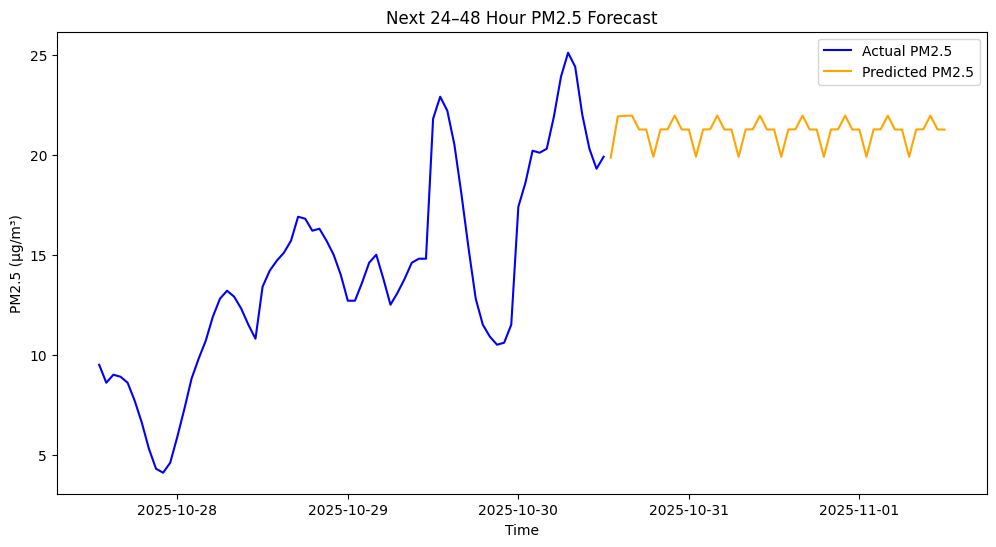

In [123]:
# Visualized Predictions vs Actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(merged['utc_time'], merged['pm25'], label='Actual PM2.5', color='blue')
plt.plot(forecast_df['utc_time'], forecast_df['pm25_pred'], label='Predicted PM2.5', color='orange')
plt.title('Next 24–48 Hour PM2.5 Forecast')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

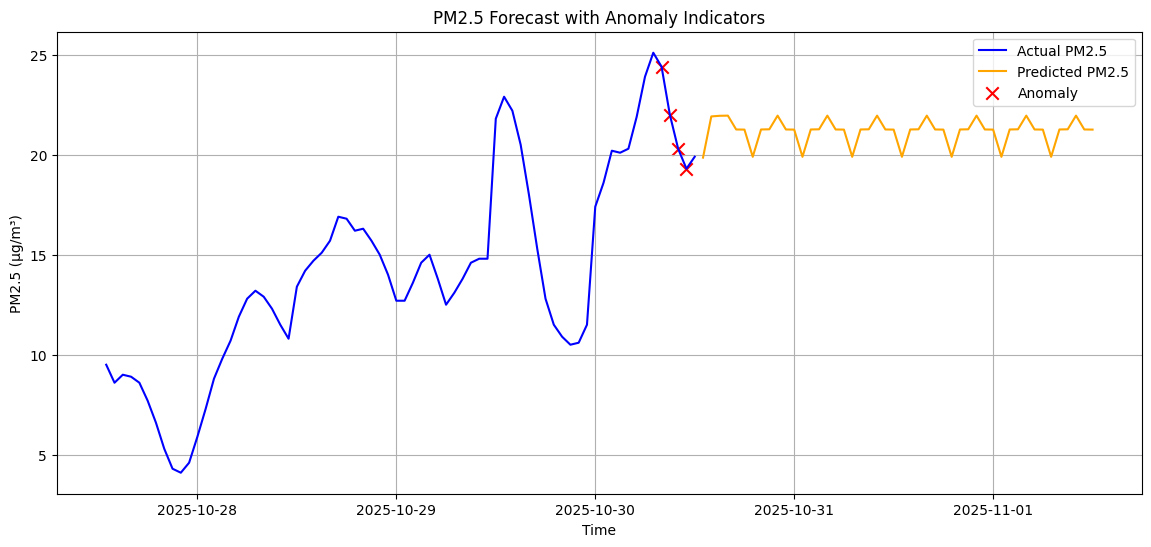

In [124]:
# Visualized Predictions vs Actual with Anomalies
plt.figure(figsize=(14,6))

# Plot historical PM2.5
plt.plot(merged['utc_time'], merged['pm25'], label='Actual PM2.5', color='blue')

# Plot forecasted PM2.5
plt.plot(forecast_df['utc_time'], forecast_df['pm25_pred'], label='Predicted PM2.5', color='orange')

# Highlight anomalies in historical data
anomaly_points = merged[merged['anomaly'] == -1]
plt.scatter(anomaly_points['utc_time'], anomaly_points['pm25'],
            color='red', label='Anomaly', marker='x', s=80)

plt.title('PM2.5 Forecast with Anomaly Indicators')
plt.xlabel('Time')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.grid(True)
plt.show()

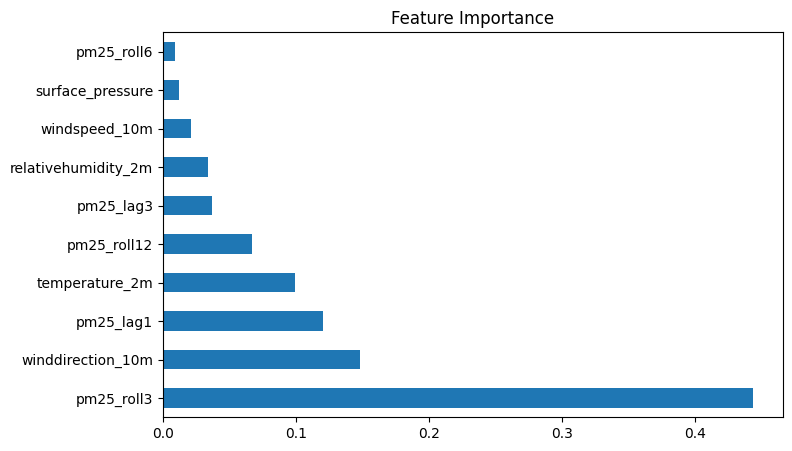

In [125]:
# Feature Importance Analysis - Check which lags or rolling averages are most important
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(10).plot(kind='barh', title='Feature Importance', figsize=(8,5))
plt.show()

In [126]:
# Step 1 — Install & set up
!pip install -q streamlit
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64

In [127]:
%%writefile LivePM.py
import warnings
# Suppress Streamlit ScriptRunContext warning in bare mode
warnings.filterwarnings("ignore", message="Thread 'MainThread': missing ScriptRunContext!")

import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta, timezone
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import streamlit as st  # Moved here so it's available globally

st.set_page_config(page_title="PM2.5 Forecast & Anomaly Detection", layout="wide")
st.title("🟢 PM2.5 Forecasting & Anomaly Detection (No Visuals)")

# ===============================
# Sidebar Inputs
# ===============================
st.sidebar.header("📍 Location Input")
lat = st.sidebar.number_input("Latitude", value=13.0827)
lon = st.sidebar.number_input("Longitude", value=80.2707)
forecast_hours = st.sidebar.slider("Forecast Hours", min_value=1, max_value=48, value=24)

# ===============================
# Fetch Functions
# ===============================
def fetch_openmeteo_pm25(lat, lon):
    end_date = datetime.now(timezone.utc)
    start_date = end_date - timedelta(hours=72)
    url = "https://air-quality-api.open-meteo.com/v1/air-quality"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "pm2_5",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    js = r.json()["hourly"]
    df = pd.DataFrame({
        "utc_time": pd.to_datetime(js["time"], utc=True),
        "pm25": js["pm2_5"]
    })
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df


def fetch_openmeteo_weather(lat, lon):
    end_date = datetime.now(timezone.utc)
    start_date = end_date - timedelta(hours=72)
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m,surface_pressure",
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d"),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    hourly = r.json()["hourly"]
    df = pd.DataFrame({"utc_time": pd.to_datetime(hourly["time"], utc=True)})
    for k, v in hourly.items():
        if k != "time":
            df[k] = v
    df = df[(df["utc_time"] >= start_date) & (df["utc_time"] <= end_date)]
    return df


# ===============================
# Fetch and Merge Data
# ===============================
with st.spinner("Fetching PM2.5 and weather data..."):
    pm25_data = fetch_openmeteo_pm25(lat, lon)
    weather_data = fetch_openmeteo_weather(lat, lon)
    merged = pd.merge_asof(
        pm25_data.sort_values("utc_time"),
        weather_data.sort_values("utc_time"),
        on="utc_time",
        direction="nearest",
        tolerance=pd.Timedelta("1h")
    )

# ===============================
# Feature Engineering
# ===============================
for lag in [1, 2, 3]:
    merged[f"pm25_lag{lag}"] = merged["pm25"].shift(lag)
merged['pm25_roll3'] = merged['pm25'].rolling(window=3).mean()
merged['pm25_roll6'] = merged['pm25'].rolling(window=6).mean()
merged['pm25_roll12'] = merged['pm25'].rolling(window=12).mean()
merged['target_pm25'] = merged['pm25'].shift(-1)
merged.bfill(inplace=True)
merged.ffill(inplace=True)

# ===============================
# Anomaly Detection
# ===============================
features_iso = [
    'pm25', 'temperature_2m', 'relativehumidity_2m', 'windspeed_10m',
    'surface_pressure', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3',
    'pm25_roll3', 'pm25_roll6', 'pm25_roll12', 'target_pm25'
]
iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso.fit(merged[features_iso])
merged['anomaly'] = iso.predict(merged[features_iso])

# ===============================
# Model Training
# ===============================
y = merged['target_pm25']
X = merged.drop(columns=['utc_time', 'pm25', 'target_pm25', 'anomaly'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

st.subheader("📊 Model Performance Metrics")
st.write(f"**MAE:** {mae:.2f}")
st.write(f"**RMSE:** {rmse:.2f}")
st.write(f"**R² Score:** {r2:.2f}")

# ===============================
# Recursive Forecast
# ===============================
last_row = merged.iloc[-1].copy()
predictions = []
model_features = model.feature_names_in_

for i in range(forecast_hours):
    X_input = last_row[model_features].to_frame().T
    y_pred = model.predict(X_input)[0]
    predictions.append(y_pred)

    # Update lag features
    last_row['pm25_lag3'] = last_row['pm25_lag2']
    last_row['pm25_lag2'] = last_row['pm25_lag1']
    last_row['pm25_lag1'] = y_pred

    # Update rolling statistics
    last_row['pm25_roll3'] = np.mean([
        last_row['pm25_lag1'], last_row['pm25_lag2'], last_row['pm25_lag3']
    ])
    last_row['pm25_roll6'] = (last_row['pm25_roll6'] * 5 + y_pred) / 6
    last_row['pm25_roll12'] = (last_row['pm25_roll12'] * 11 + y_pred) / 12

    # Increment timestamp
    last_row['utc_time'] += pd.Timedelta(hours=1)

forecast_times = [
    merged['utc_time'].iloc[-1] + pd.Timedelta(hours=i + 1)
    for i in range(forecast_hours)
]
forecast_df = pd.DataFrame({
    'utc_time': forecast_times,
    'pm25_pred': predictions
})

# ===============================
# Display Data
# ===============================
st.subheader("🗂️ Historical PM2.5 & Weather Data")
st.dataframe(merged.tail(20))

st.subheader("🗂️ Forecasted PM2.5 for Next Hours")
st.dataframe(forecast_df)

Overwriting LivePM.py


In [132]:
!pkill cloudflared
!pkill streamlit
!sleep 3

!nohup streamlit run /content/LivePM.py --server.port 8501 &>/content/streamlit.log &
!sleep 10

!nohup ./cloudflared-linux-amd64 tunnel --url http://localhost:8501 > /content/tunnel.log 2>&1 &
!sleep 5

!grep -o 'https://.*\.trycloudflare.com' /content/tunnel.log

https://connectors-grateful-visual-elizabeth.trycloudflare.com


In [128]:
!streamlit run /content/LivePm.py &>/content/logs.txt &

In [129]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"

Your tunnel url https://black-concentrations-workstation-outdoor.trycloudflare.com
